In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from numpy import array
from math import sqrt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import keras.backend as K
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kruskal, shapiro, levene
import seaborn as sns
from random import random
#!pip install pmdarima --quiet
import pmdarima as pm

# Code adapted from https://medium.com/data-science/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
# Plot data to view
def plot_data(df, feature):
    plt.figure(figsize=(15,7))
    plt.title(str(feature)+" by Month")
    plt.xlabel('Month')
    plt.ylabel(str(feature))
    plt.plot(df)
    plt.show()

#Determine rolling statistics to find trends
def rolling_statistics(df):
    df["rolling_avg"] = df[df.columns[0]].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
    df["rolling_std"] = df[df.columns[0]].rolling(window=12).std()

    #Plot rolling statistics
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#379BDB', label='Original')
    plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
    plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#Augmented Dickey-Fuller Test to test if the time series is stationary
#If ADF has p <= 0.05, data are stationary
def ADF(df, feature):
    print('Results of Dickey Fuller Test for '+feature+':')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

    return dfoutput

def add_padding(y):

    # Create rows of padding with zeros
    if isinstance(y[0][0], float) or isinstance(y[0][0], int):
        n_vars = 1
    else:
        n_vars = len(y[0][0])

    if n_vars == 1:
        padding = 0 * n_vars
    else:
        padding = [0 * n_vars]

    data = []
    
    for p in range(len(y)):
        for q in range(len(y[0])):
            data.append(y[p][q])
        
        for r in range(12):
            data.append(padding)

    return data

# Standard ARIMA Model
def fit_ARIMA_model(temp, temp_val, temp_test, sh, sh_val, sh_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []
    best_rmse_temp = -1
    best_rmse_sh = -1

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    
    y1_list = temp[0]
    y2_list = sh[0]
    y1_val = temp_val[0]
    y1_test = temp_test[0]
    y2_val = sh_val[0]
    y2_test = sh_test[0]

    print(len(temp[0]))
    print(len(temp_val[0]))
    print(len(temp_test[0]))
    print(len(y1_list))

    for q in range(10):
        y1_list.append(y1_val[q])
        y2_list.append(y2_val[q])

    for r in range(11):
        y1_list.append(y1_test[r])
        y2_list.append(y2_test[r])

    for j in range(len(y1_list)):
        series1 = pd.Series(y1_list[j])
        series2 = pd.Series(y2_list[j])
        y1 = np.array(y1_list[j])
        y2 = np.array(y2_list[j])

        # Reconstruct the data frame with standardized values
        data = pd.DataFrame({'y1': y1, 'y2': y2}, index=dates)

        model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

        model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
        model1_fit = model1.fit(y1_val[0])
        print(model1_fit.summary())

        model2_fit = model2.fit(y2_val[0])
        print(model2_fit.summary())

        #Make predictions
        predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

        #Make predictions
        predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

        # Get actual values to compare against predictions
        actual1 = []
        for i1 in range(10):
            xtwo = y1_list[j]
            ztwo = []
            for c1 in reversed(range(n_seq)):
                ztwo.append(xtwo[len(series1)-1-c1])
            if n_seq == 1:
                actual1.append(ztwo[0])
            else:
                actual1.append(ztwo)

        actual2 = []
        for i2 in range(10):
            xthree = y2_list[j]
            zthree = []
            for c2 in reversed(range(n_seq)):
                zthree.append(xthree[len(series2)-1-c2])
            if n_seq == 1:
                actual2.append(zthree[0])
            else:
                actual2.append(zthree)

        print("Actuals:")
        print(actual1)
        print(actual2)
        print("Predicted:")
        print(predictions1)
        print(predictions2)
                    
        #Calculate the Root Mean Square Error (RMSE)
        mse1 = mean_squared_error(actual1, predictions1)
        rmse1 = np.sqrt(mse1)
        mae1 = mean_absolute_error(actual1, predictions1)
        mape1 = mean_absolute_percentage_error(actual1, predictions1)
        r2a = r2_score(actual1, predictions1)
        cv1_errors.append(rmse1)
        cv1_mae.append(mae1)
        cv1_mape.append(mape1)
        cv1_r2.append(r2a)

        #Calculate the Root Mean Square Error (RMSE)
        mse2 = mean_squared_error(actual2, predictions2)
        rmse2 = np.sqrt(mse2)
        mae2 = mean_absolute_error(actual2, predictions2)
        mape2 = mean_absolute_percentage_error(actual2, predictions2)
        r2b = r2_score(actual2, predictions2)
        cv2_errors.append(rmse2)
        cv2_mae.append(mae2)
        cv2_mape.append(mape2)
        cv2_r2.append(r2b)

        print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
        print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))     

        if best_rmse_temp == -1:
            best_model1 = model1
            best_rmse_temp = rmse1
        elif best_rmse_temp > rmse1:
            best_model1 = model1
            best_rmse_temp = rmse1

        if best_rmse_sh == -1:
            best_model2 = model2
            best_rmse_sh = rmse2
        elif best_rmse_sh > rmse2:
            best_model2 = model2
            best_rmse_sh = rmse2            
        
    print("Temperature Metrics:")
    print("RMSE values:")
    print(cv1_errors)
    print("MAE values:")
    print(cv1_mae)
    print("MAPE values:")
    print(cv1_mape)
    print("R2 scores:")
    print(cv1_r2)
    print("")
    print("Specific Humidity Metrics:")
    print("RMSE values:")
    print(cv2_errors)
    print("MAE values:")
    print(cv2_mae)
    print("MAPE values:")
    print(cv2_mape)
    print("R2 scores:")
    print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return best_model1, best_model2

# ARIMA Model
def fit_auto_ARIMA_model(temp, temp_val, temp_test, sh, sh_val, sh_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []
    best_rmse_temp = -1
    best_rmse_sh = -1

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    
    for k in range(5):
        y1_list = temp[k]
        y2_list = sh[k]
        y1_val = temp_val[k]
        y1_test = temp_test[k]
        y2_val = sh_val[k]
        y2_test = sh_test[k]
        for j in range(len(y1_list)):
            series1 = pd.Series(y1_list[j])
            series2 = pd.Series(y2_list[j])
            y1 = np.array(y1_list[j])
            y2 = np.array(y2_list[j])

            # Reconstruct the data frame with standardized values
            data = pd.DataFrame({'y1': y1, 'y2': y2}, index=dates)

            model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

            model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
            model1_fit = model1.fit(y1_val[0])
            print(model1_fit.summary())

            model2_fit = model2.fit(y2_val[0])
            print(model2_fit.summary())

            #Make predictions
            predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

            #Make predictions
            predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

            # Get actual values to compare against predictions
            actual1 = []
            for i1 in range(len(temp_val[k])):
                xtwo = y1_val[0]
                ztwo = []
                for c1 in reversed(range(n_seq)):
                    ztwo.append(xtwo[len(series1)-1-c1])
                if n_seq == 1:
                    actual1.append(ztwo[0])
                else:
                    actual1.append(ztwo)

            actual2 = []
            for i2 in range(10):
                xthree = y2_val[0]
                zthree = []
                for c2 in reversed(range(n_seq)):
                    zthree.append(xthree[len(series2)-1-c2])
                if n_seq == 1:
                    actual2.append(zthree[0])
                else:
                    actual2.append(zthree)

            print("Actuals:")
            print(actual1)
            print(actual2)
            print("Predicted:")
            print(predictions1)
            print(predictions2)
                    
            #Calculate the Root Mean Square Error (RMSE)
            mse1 = mean_squared_error(actual1, predictions1)
            rmse1 = np.sqrt(mse1)
            mae1 = mean_absolute_error(actual1, predictions1)
            mape1 = mean_absolute_percentage_error(actual1, predictions1)
            r2a = r2_score(actual1, predictions1)
            cv1_errors.append(rmse1)
            cv1_mae.append(mae1)
            cv1_mape.append(mape1)
            cv1_r2.append(r2a)

            #Calculate the Root Mean Square Error (RMSE)
            mse2 = mean_squared_error(actual2, predictions2)
            rmse2 = np.sqrt(mse2)
            mae2 = mean_absolute_error(actual2, predictions2)
            mape2 = mean_absolute_percentage_error(actual2, predictions2)
            r2b = r2_score(actual2, predictions2)
            cv2_errors.append(rmse2)
            cv2_mae.append(mae2)
            cv2_mape.append(mape2)
            cv2_r2.append(r2b)

            print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
            print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))     

            if best_rmse_temp == -1:
                best_model1 = model1
                best_rmse_temp = rmse1
            elif best_rmse_temp > rmse1:
                best_model1 = model1
                best_rmse_temp = rmse1

            if best_rmse_sh == -1:
                best_model2 = model2
                best_rmse_sh = rmse2
            elif best_rmse_sh > rmse2:
                best_model2 = model2
                best_rmse_sh = rmse2   
        
        print("Fold "+str(k)+":")
        print("Temperature Metrics:")
        print("RMSE values:")
        print(cv1_errors)
        print("MAE values:")
        print(cv1_mae)
        print("MAPE values:")
        print(cv1_mape)
        print("R2 scores:")
        print(cv1_r2)
        print("")
        print("Specific Humidity Metrics:")
        print("RMSE values:")
        print(cv2_errors)
        print("MAE values:")
        print(cv2_mae)
        print("MAPE values:")
        print(cv2_mape)
        print("R2 scores:")
        print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return best_model1, best_model2
    
# SARIMAX Model
def fit_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []
    best_rmse_temp = -1
    best_rmse_sh = -1

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    exog1 = []
    exog2 = []
    exog3 = []
    
    y1_list = temp[0]
    y2_list = sh[0]
    y1_val = temp_val[0]
    y1_test = temp_test[0]
    y2_val = sh_val[0]
    y2_test = sh_test[0]
    PC1_list = PC1[0]
    PC1_list_val = PC1_val[0]
    PC1_list_test = PC1_test[0]
    PC2_list = PC2[0]
    PC2_list_val = PC2_val[0]
    PC2_list_test = PC2_test[0]
    PC3_list = PC3[0]
    PC3_list_val = PC3_val[0]
    PC3_list_test = PC3_test[0]

    print(len(temp[0]))
    print(len(temp_val[0]))
    print(len(temp_test[0]))
    print(len(y1_list))

    for q in range(10):
        y1_list.append(y1_val[q])
        y2_list.append(y2_val[q])
        PC1_list.append(PC1_list_val[q])
        PC2_list.append(PC2_list_val[q])
        PC3_list.append(PC3_list_val[q])

    for r in range(11):
        y1_list.append(y1_test[r])
        y2_list.append(y2_test[r])
        PC1_list.append(PC1_list_test[r])
        PC2_list.append(PC2_list_test[r])
        PC3_list.append(PC3_list_test[r])

    for j in range(len(y1_list)):
        series1 = pd.Series(y1_list[j])
        series2 = pd.Series(y2_list[j])
        y1 = np.array(y1_list[j])
        y2 = np.array(y2_list[j])
        exog1 = np.array(PC1_list[j])
        exog2 = np.array(PC2_list[j])
        exog3 = np.array(PC3_list[j])

        # Reconstruct the data frame with standardized values
        data = pd.DataFrame({'y1': y1, 'y2': y2, 'exog1': exog1, 'exog2': exog2, 'exog3': exog3}, index=dates)

        # Define the exogenous variables
        exog = data[['exog1', 'exog2', 'exog3']]

        model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

        model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
        model1_fit = model1.fit(y1_val[0])
        print(model1_fit.summary())

        model2_fit = model2.fit(y2_val[0])
        print(model2_fit.summary())

        #Make predictions
        predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

        #Make predictions
        predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

        # Get actual values to compare against predictions
        actual1 = []
        for i1 in range(10):
            xtwo = y1_list[j]
            ztwo = []
            for c1 in reversed(range(n_seq)):
                ztwo.append(xtwo[len(series1)-1-c1])
            if n_seq == 1:
                actual1.append(ztwo[0])
            else:
                actual1.append(ztwo)

        actual2 = []
        for i2 in range(10):
            xthree = y2_list[j]
            zthree = []
            for c2 in reversed(range(n_seq)):
                zthree.append(xthree[len(series2)-1-c2])
            if n_seq == 1:
                actual2.append(zthree[0])
            else:
                actual2.append(zthree)

        print("Actuals:")
        print(actual1)
        print(actual2)
        print("Predicted:")
        print(predictions1)
        print(predictions2)
                    
        #Calculate the Root Mean Square Error (RMSE)
        mse1 = mean_squared_error(actual1, predictions1)
        rmse1 = np.sqrt(mse1)
        mae1 = mean_absolute_error(actual1, predictions1)
        mape1 = mean_absolute_percentage_error(actual1, predictions1)
        r2a = r2_score(actual1, predictions1)
        cv1_errors.append(rmse1)
        cv1_mae.append(mae1)
        cv1_mape.append(mape1)
        cv1_r2.append(r2a)

        #Calculate the Root Mean Square Error (RMSE)
        mse2 = mean_squared_error(actual2, predictions2)
        rmse2 = np.sqrt(mse2)
        mae2 = mean_absolute_error(actual2, predictions2)
        mape2 = mean_absolute_percentage_error(actual2, predictions2)
        r2b = r2_score(actual2, predictions2)
        cv2_errors.append(rmse2)
        cv2_mae.append(mae2)
        cv2_mape.append(mape2)
        cv2_r2.append(r2b)

        print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
        print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))       

        if best_rmse_temp == -1:
            best_model1 = model1
            best_rmse_temp = rmse1
        elif best_rmse_temp > rmse1:
            best_model1 = model1
            best_rmse_temp = rmse1

        if best_rmse_sh == -1:
            best_model2 = model2
            best_rmse_sh = rmse2
        elif best_rmse_sh > rmse2:
            best_model2 = model2
            best_rmse_sh = rmse2   
        
    print("Temperature Metrics:")
    print("RMSE values:")
    print(cv1_errors)
    print("MAE values:")
    print(cv1_mae)
    print("MAPE values:")
    print(cv1_mape)
    print("R2 scores:")
    print(cv1_r2)
    print("")
    print("Specific Humidity Metrics:")
    print("RMSE values:")
    print(cv2_errors)
    print("MAE values:")
    print(cv2_mae)
    print("MAPE values:")
    print(cv2_mape)
    print("R2 scores:")
    print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return best_model1, best_model2

# SARIMAX Model
def fit_auto_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []
    best_rmse_temp = -1
    best_rmse_sh = -1

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    exog1 = []
    exog2 = []
    exog3 = []
    
    for k in range(5):
        y1_list = temp[k]
        y2_list = sh[k]
        y1_val = temp_val[k]
        y1_test = temp_test[k]
        y2_val = sh_val[k]
        y2_test = sh_test[k]
        PC1_list = PC1[k]
        PC2_list = PC2[k]
        PC3_list = PC3[k]
        for j in range(len(y1_list)):
            series1 = pd.Series(y1_list[j])
            series2 = pd.Series(y2_list[j])
            y1 = np.array(y1_list[j])
            y2 = np.array(y2_list[j])
            exog1 = np.array(PC1_list[j])
            exog2 = np.array(PC2_list[j])
            exog3 = np.array(PC3_list[j])

            # Reconstruct the data frame with standardized values
            data = pd.DataFrame({'y1': y1, 'y2': y2, 'exog1': exog1, 'exog2': exog2, 'exog3': exog3}, index=dates)

            # Define the exogenous variables
            exog = data[['exog1', 'exog2', 'exog3']]

            model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

            model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
            model1_fit = model1.fit(y1_val[0])
            print(model1_fit.summary())

            model2_fit = model2.fit(y2_val[0])
            print(model2_fit.summary())

            #Make predictions
            predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

            #Make predictions
            predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

            # Get actual values to compare against predictions
            actual1 = []
            for i1 in range(len(temp_val[k])):
                xtwo = y1_val[0]
                ztwo = []
                for c1 in reversed(range(n_seq)):
                    ztwo.append(xtwo[len(series1)-1-c1])
                if n_seq == 1:
                    actual1.append(ztwo[0])
                else:
                    actual1.append(ztwo)

            actual2 = []
            for i2 in range(10):
                xthree = y2_val[0]
                zthree = []
                for c2 in reversed(range(n_seq)):
                    zthree.append(xthree[len(series2)-1-c2])
                if n_seq == 1:
                    actual2.append(zthree[0])
                else:
                    actual2.append(zthree)

            print("Actuals:")
            print(actual1)
            print(actual2)
            print("Predicted:")
            print(predictions1)
            print(predictions2)
                    
            #Calculate the Root Mean Square Error (RMSE)
            mse1 = mean_squared_error(actual1, predictions1)
            rmse1 = np.sqrt(mse1)
            mae1 = mean_absolute_error(actual1, predictions1)
            mape1 = mean_absolute_percentage_error(actual1, predictions1)
            r2a = r2_score(actual1, predictions1)
            cv1_errors.append(rmse1)
            cv1_mae.append(mae1)
            cv1_mape.append(mape1)
            cv1_r2.append(r2a)

            #Calculate the Root Mean Square Error (RMSE)
            mse2 = mean_squared_error(actual2, predictions2)
            rmse2 = np.sqrt(mse2)
            mae2 = mean_absolute_error(actual2, predictions2)
            mape2 = mean_absolute_percentage_error(actual2, predictions2)
            r2b = r2_score(actual2, predictions2)
            cv2_errors.append(rmse2)
            cv2_mae.append(mae2)
            cv2_mape.append(mape2)
            cv2_r2.append(r2b)

            print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
            print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))        

            if best_rmse_temp == -1:
                best_model1 = model1
                best_rmse_temp = rmse1
            elif best_rmse_temp > rmse1:
                best_model1 = model1
                best_rmse_temp = rmse1

            if best_rmse_sh == -1:
                best_model2 = model2
                best_rmse_sh = rmse2
            elif best_rmse_sh > rmse2:
                best_model2 = model2
                best_rmse_sh = rmse2   
        
        print("Fold "+str(k)+":")
        print("Temperature Metrics:")
        print("RMSE values:")
        print(cv1_errors)
        print("MAE values:")
        print(cv1_mae)
        print("MAPE values:")
        print(cv1_mape)
        print("R2 scores:")
        print(cv1_r2)
        print("")
        print("Specific Humidity Metrics:")
        print("RMSE values:")
        print(cv2_errors)
        print("MAE values:")
        print(cv2_mae)
        print("MAPE values:")
        print(cv2_mape)
        print("R2 scores:")
        print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return best_model1, best_model2

def plot_diagnostics(model):
    model.plot_diagnostics(figsize=(15,12))
    plt.show
    
def ARIMA_forecast(ARIMA_model, df, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make a series for plotting purposes
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

def SARIMAX_forecast(SARIMAX_model, df, exog, periods=12):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=exog)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))

# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into training sets
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        train.append([scaled_values_batch])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([scaled_values_batch])
        else:
            validation.append([scaled_values_batch])
    
    return validation, test

def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))

def transform_data(data, n_lag, n_seq):
    
    X_row = []
    y_row = []
    temp_row = []
    sh_row = []
    PC1_row = []
    PC2_row = []
    PC3_row = []
    for j in range(len(data)):
        X2 = data[j]
        y2 = pd.DataFrame(X2[n_seq:n_lag+n_seq])
        X_row.append(pd.DataFrame(X2[:n_lag]))
        temp_row.append(X_row[j][X_row[j].columns[0]])
        sh_row.append(X_row[j][X_row[j].columns[1]])
        PC1_row.append(X_row[j][X_row[j].columns[2]])
        PC2_row.append(X_row[j][X_row[j].columns[3]])
        PC3_row.append(X_row[j][X_row[j].columns[4]])
        y_row.append(y2[y2.columns[0]])

    return X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row

#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])

#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])

train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10

#X1 = slp	
#X2 = wbt	
#X3 = water	
#X4 = GHI
#X5 = WDSP
#X6 = PRCP	
#X7 = SNDP	
#X8 = Region	
#X9 = SA	
#X10 = ONI

# Get the current working directory 
current_directory = os.getcwd() 

# Print the current working directory 
print(current_directory)

# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)

filename = path + 'Final_Monthly_Dataset.csv'

# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)

# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['date', 'latitude', 'longitude', 'elevation'], axis=1)

results_df = df_trimmed

# Calculate principal components excluding response variables
results_df['PC1']=-0.0004514*results_df['slp']+0.03194*results_df['wet_bulb_temperature']-0.04343*results_df['water']+0.002243*results_df['GHI']-0.02252*results_df['WDSP']
+0.9877*results_df['PRCP']-0.2265*results_df['SNDP']+0.006144*results_df['region']-0.0001488*results_df['solar_activity']+0.02943*results_df['ONI']
results_df['PC2']=0.0001702*results_df['slp']+0.005484*results_df['wet_bulb_temperature']+0.2057*results_df['water']-0.0003188*results_df['GHI']-0.02584*results_df['WDSP']
+1.6963*results_df['PRCP']-0.05890*results_df['SNDP']+0.05809*results_df['region']+1.9748*results_df['solar_activity']+0.03686*results_df['ONI']
results_df['PC3']=-0.00006323*results_df['slp']-0.001180*results_df['wet_bulb_temperature']-0.02384*results_df['water']-0.00002833*results_df['GHI']+0.01170*results_df['WDSP']
+0.5204*results_df['PRCP']+0.4791*results_df['SNDP']-0.004318*results_df['region']+0.008271*results_df['solar_activity']+0.8765*results_df['ONI']

# Drop columns that compose principal components
results_df = results_df.drop(['slp', 'wet_bulb_temperature', 'water', 'GHI', 'WDSP', 'PRCP', 'SNDP', 'region', 'solar_activity', 'ONI'], axis=1)

print(results_df)

print(results_df.columns)

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = results_df[results_df['file_id'] == i].drop(['file_id', 'Year', 'Month'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and n_vars features 
train_y = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and 1 feature (response variable)
val_X = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and n_vars features 
val_y = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and 1 feature (response variable)
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
        val_X_rows.append(X[j])
        val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows)

#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)    

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])

    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
       file_id  temperatures  specific_humidity    Year  Month       PC1  \
0         6501         12.21               5.39  2006.0    1.0 -0.155299   
1         6501          8.17               4.30  2006.0    2.0 -0.193200   
2         6501         15.68               6.51  2006.0    3.0  0.093451   
3         6501         22.46              10.21  2006.0    4.0  0.456252   
4         6501         23.66              11.74  2006.0    5.0  0.566777   
...        ...           ...                ...     ...    ...       ...   
24057     9858         28.60              15.21  2024.0    7.0       NaN   
24058     9858         29.11              15.15  2024.0    8.0       NaN   
24059     9858         24.57              10.72  2024.0    9.0       NaN   
24060     9858         21.16               6.99  2024.0   10.0       NaN   
24061     9

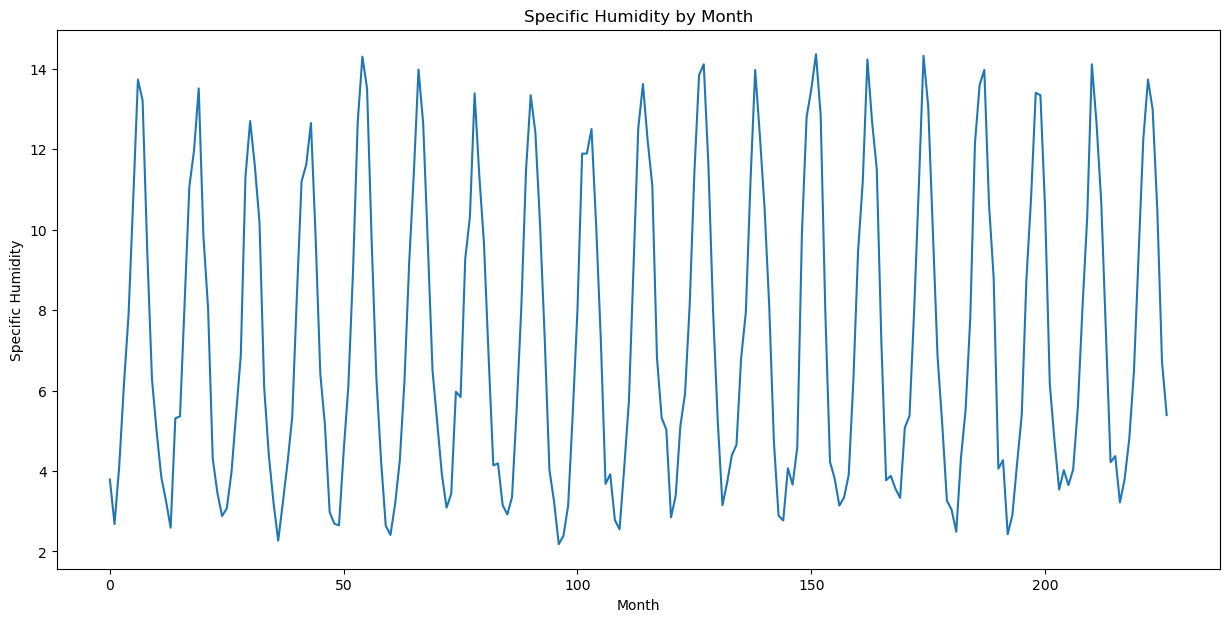

In [ ]:
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

train1 = train[0]
test1 = test[0]
validation1 = validation[0]

# Aggregate the original data by getting the median of the weather station specific humidity for each month
y_df = results_df.groupby(['Year', 'Month'])['specific_humidity'].median()
y1 = y_df.values

data = []
for j in range(len(train1)):
    ws_row = []
    for k in range(len(train1[0])):
        Q = train1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity
for j in range(len(test1)):
    ws_row = []
    for k in range(len(test1[0])):
        Q = test1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity
for j in range(len(validation1)):
    ws_row = []
    for k in range(len(validation1[0])):
        Q = validation1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity

# Aggregate the transformed data by getting the median of the weather station specific humidity for each month
y_scaled = []

for j in range(len(data[0])):
    ws_row = [] # holds all 105 weather station's specific humidity for the same time step to get median value
    for k in range(len(data)):
        ws_row.append(data[k][j])
    y_scaled.append(np.median(ws_row))

# Plot data
plot_data(y1, "Specific Humidity")

#Get rolling statistics
rolling_statistics(pd.DataFrame(y1))

# Run Dickey-Fuller test to check if stationary
ADF(y_scaled, "Specific Humidity")
ADF(y1, "Specific Humidity")

#Run Kruskal-Wallis H Test to check if the population median of each weather station is the same
kruskal_stat, kruskal_pval = kruskal(*[results_df[results_df['file_id'] == f]['specific_humidity'] for f in results_df['file_id'].unique()])

print(kruskal_stat)
print(kruskal_pval)
    
#Run Shapiro-Wilk Test for normality
normality_test_results = {}
for ws in results_df['file_id'].unique():
    w, pvalue = shapiro(results_df[results_df['file_id'] == ws]['specific_humidity'])
    normality_test_results[ws] = pvalue
        
# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(*[results_df[results_df['file_id'] == ws]['specific_humidity'] for ws in results_df['file_id'].unique()])

print("Shapiro-Wilk Test for Normality:")
print(normality_test_results)
print("Levene's Test for Homogeneity of Variances:")
print(levene_stat)
print("Levene p: "+str(levene_p))

# Generate ACF and PACF plots
fig1, axes1 = plt.subplots(2, 1, figsize=(14, 12))

print("Scaled Data:")

# Plot ACF
plot_acf(pd.DataFrame(y_scaled), ax=axes1[0], lags=30, alpha=0.05)
axes1[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(pd.DataFrame(y_scaled), ax=axes1[1], lags=30, alpha=0.05, method='ywm')
axes1[1].set_title('Partial Autocorrelation Function (PACF)')

print("Unscaled Data:")

# Generate ACF and PACF plots
fig2, axes2 = plt.subplots(2, 1, figsize=(14, 12))

# Plot ACF
plot_acf(y_df, ax=axes2[0], lags=30, alpha=0.05)
axes2[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y_df, ax=axes2[1], lags=30, alpha=0.05, method='ywm')
axes2[1].set_title('Partial Autocorrelation Function (PACF)')

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(y=results_df['specific_humidity'])
plt.title('Box Plot of Specific Humidity')
plt.xlabel('Specific Humidity')
plt.show()

# Decomposing the time series with an appropriate period based on the data's seasonality
decomposition_filled = seasonal_decompose(y_df, model='additive', period=12) # Monthly seasonality

# Plotting the decomposed components of the time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
decomposition_filled.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Month')
ax1.set_ylabel('Specific Humidity')

decomposition_filled.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Month')
ax2.set_ylabel('Specific Humidity')

decomposition_filled.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Month')
ax3.set_ylabel('Specific Humidity')

plt.tight_layout()
plt.show()

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 3)   Log Likelihood                 223.463
Date:                Sun, 01 Jun 2025   AIC                           -418.926
Time:                        02:49:47   BIC                           -374.303
Sample:                             0   HQIC                          -400.832
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4925      0.357      4.183      0.000       0.793       2.192
ar.L1         -0.0756      0.290     -0.261      0.794      -0.643       0.492
ar.L2          0.0253      0.279      0.091      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        02:49:53   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        02:50:03   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        02:50:04   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        02:50:14   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        02:50:15   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        02:51:44   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        02:51:45   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(0, 0, 3)   Log Likelihood                 105.552
Date:                Sun, 01 Jun 2025   AIC                           -201.103
Time:                        02:53:20   BIC                           -185.166
Sample:                             0   HQIC                          -194.641
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5010      0.023     21.636      0.000       0.456       0.546
ma.L1          0.5570      0.069      8.073      0.000       0.422       0.692
ma.L2          0.4280      0.070      6.088      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 2)   Log Likelihood                 263.334
Date:                Sun, 01 Jun 2025   AIC                           -500.668
Time:                        02:53:24   BIC                           -459.232
Sample:                             0   HQIC                          -483.866
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8756      0.160     11.695      0.000       1.561       2.190
ar.L1         -0.0742      0.145     -0.512      0.609      -0.358       0.210
ar.L2         -0.1349      0.093     -1.452      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:04:54   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:04:55   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:06:35   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:06:36   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 1)   Log Likelihood                 221.303
Date:                Sun, 01 Jun 2025   AIC                           -418.605
Time:                        03:07:52   BIC                           -380.356
Sample:                             0   HQIC                          -403.095
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7223      0.194      8.896      0.000       1.343       2.102
ar.L1          0.0354      0.101      0.349      0.727      -0.163       0.234
ar.L2         -0.3705      0.067     -5.550      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 191.175
Date:                Sun, 01 Jun 2025   AIC                           -372.349
Time:                        03:07:55   BIC                           -356.412
Sample:                             0   HQIC                          -365.887
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1693      0.018      9.585      0.000       0.135       0.204
ar.L1          1.4964      0.048     31.093      0.000       1.402       1.591
ar.L2         -0.8337      0.047    -17.929      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(0, 0, 7)   Log Likelihood                 132.621
Date:                Sun, 01 Jun 2025   AIC                           -247.241
Time:                        03:10:23   BIC                           -218.555
Sample:                             0   HQIC                          -235.609
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5033      0.002    291.232      0.000       0.500       0.507
ma.L1          0.3608      0.175      2.066      0.039       0.019       0.703
ma.L2          0.1509      0.247      0.611      0.5

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Sun, 01 Jun 2025   AIC                           -528.152
Time:                        03:10:25   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:10:36   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:10:36   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:10:47   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:10:48   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:10:59   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:10:59   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 201.754
Date:                Sun, 01 Jun 2025   AIC                           -385.508
Time:                        03:11:45   BIC                           -356.822
Sample:                             0   HQIC                          -373.876
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6579      0.045     14.680      0.000       0.570       0.746
ar.L1          0.4003      0.076      5.298      0.000       0.252       0.548
ar.L2         -0.0325      0.081     -0.402      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:11:45   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:11:56   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:11:56   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:15:08   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:15:13   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:15:22   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:15:22   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:15:30   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:15:30   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:18:22   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644]
[0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957]
Predicted:
179    0.493915
180    0.582262
181    0.654119
182    0.698511
183    0.725547
184    0.663610
185    0.559632
186    0.431280
187    0.334559
188    0.286751
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 30 Temperature RMSE value: 0.28261925951885025
Weather Station 30 Specific Humidity RMSE value: 0.13287555151415684


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:19:46   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:19:46   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 230.008
Date:                Sun, 01 Jun 2025   AIC                           -430.016
Time:                        03:21:21   BIC                           -382.205
Sample:                             0   HQIC                          -410.629
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9705     27.827      0.143      0.887     -50.570      58.511
ar.L1         -0.6458      7.387     -0.087      0.930     -15.125      13.833
ar.L2         -0.6823      4.445     -0.153      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:22:41   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:22:41   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:22:53   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Sun, 01 Jun 2025   AIC                           -304.124
Time:                        03:22:53   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:49:54   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Sun, 01 Jun 2025   AIC                           -528.152
Time:                        03:49:56   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:50:25   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:50:27   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:50:30   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:50:32   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:50:34   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:50:48   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:50:50   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:50:53   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:51:09   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:51:23   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:51:39   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 230.008
Date:                Sun, 01 Jun 2025   AIC                           -430.016
Time:                        03:52:05   BIC                           -382.205
Sample:                             0   HQIC                          -410.629
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9705     27.827      0.143      0.887     -50.570      58.511
ar.L1         -0.6458      7.387     -0.087      0.930     -15.125      13.833
ar.L2         -0.6823      4.445     -0.153      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:52:06   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:52:23   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 230.008
Date:                Sun, 01 Jun 2025   AIC                           -430.016
Time:                        03:52:50   BIC                           -382.205
Sample:                             0   HQIC                          -410.629
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9705     27.827      0.143      0.887     -50.570      58.511
ar.L1         -0.6458      7.387     -0.087      0.930     -15.125      13.833
ar.L2         -0.6823      4.445     -0.153      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Sun, 01 Jun 2025   AIC                           -528.152
Time:                        03:52:51   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:53:19   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:53:20   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(7, 0, 1)   Log Likelihood                 202.124
Date:                Sun, 01 Jun 2025   AIC                           -384.247
Time:                        03:53:41   BIC                           -352.374
Sample:                             0   HQIC                          -371.323
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9081      0.070     12.897      0.000       0.770       1.046
ar.L1          0.2801      0.082      3.418      0.001       0.119       0.441
ar.L2         -0.2005      0.079     -2.539      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:53:42   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:54:24   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:54:25   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:54:50   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:54:51   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:55:07   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:55:36   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:55:38   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:55:53   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:56:15   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 219.439
Date:                Sun, 01 Jun 2025   AIC                           -420.878
Time:                        03:56:15   BIC                           -392.192
Sample:                             0   HQIC                          -409.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4589      0.039     11.753      0.000       0.382       0.535
ar.L1          0.8409      0.077     10.939      0.000       0.690       0.992
ar.L2          0.0278      0.095      0.294      0.7

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:56:45   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:56:46   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(7, 0, 1)   Log Likelihood                 202.124
Date:                Sun, 01 Jun 2025   AIC                           -384.247
Time:                        03:56:58   BIC                           -352.374
Sample:                             0   HQIC                          -371.323
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9081      0.070     12.897      0.000       0.770       1.046
ar.L1          0.2801      0.082      3.418      0.001       0.119       0.441
ar.L2         -0.2005      0.079     -2.539      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:57:16   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:57:46   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        03:57:47   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        03:58:09   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 164.073
Date:                Sun, 01 Jun 2025   AIC                           -314.146
Time:                        03:58:16   BIC                           -291.835
Sample:                             0   HQIC                          -305.099
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1244      0.017      7.515      0.000       0.092       0.157
ar.L1          1.6172      0.060     27.009      0.000       1.500       1.735
ar.L2         -0.8642      0.068    -12.774      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(3, 0, 4)   Log Likelihood                  89.890
Date:                Sun, 01 Jun 2025   AIC                           -163.779
Time:                        03:58:23   BIC                           -138.280
Sample:                             0   HQIC                          -153.439
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1398      0.382      0.366      0.715      -0.609       0.889
ar.L2          0.9129      0.093      9.846      0.000       0.731       1.095
ar.L3         -0.1592      0.375     -0.425      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:58:36   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 2)   Log Likelihood                 220.821
Date:                Sun, 01 Jun 2025   AIC                           -415.642
Time:                        03:59:02   BIC                           -374.206
Sample:                             0   HQIC                          -398.840
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7059      0.293      5.827      0.000       1.132       2.280
ar.L1         -0.1465      0.279     -0.525      0.600      -0.694       0.401
ar.L2         -0.1396      0.131     -1.066      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 1)   Log Likelihood                 265.948
Date:                Sun, 01 Jun 2025   AIC                           -507.897
Time:                        03:59:03   BIC                           -469.648
Sample:                             0   HQIC                          -492.387
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7113      0.119     14.330      0.000       1.477       1.945
ar.L1          0.1397      0.089      1.578      0.115      -0.034       0.313
ar.L2         -0.2486      0.061     -4.086      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:59:07   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:59:22   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        03:59:24   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        03:59:40   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        04:00:05   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Sun, 01 Jun 2025   AIC                           -528.152
Time:                        04:00:06   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 201.754
Date:                Sun, 01 Jun 2025   AIC                           -385.508
Time:                        04:00:27   BIC                           -356.822
Sample:                             0   HQIC                          -373.876
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6579      0.045     14.680      0.000       0.570       0.746
ar.L1          0.4003      0.076      5.298      0.000       0.252       0.548
ar.L2         -0.0325      0.081     -0.402      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 2)   Log Likelihood                 278.587
Date:                Sun, 01 Jun 2025   AIC                           -527.175
Time:                        04:00:28   BIC                           -479.364
Sample:                             0   HQIC                          -507.788
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5190      1.486      2.368      0.018       0.606       6.432
ar.L1         -0.4487      0.659     -0.681      0.496      -1.740       0.843
ar.L2         -0.5007      0.161     -3.109      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 182.523
Date:                Sun, 01 Jun 2025   AIC                           -351.046
Time:                        04:00:35   BIC                           -328.735
Sample:                             0   HQIC                          -341.999
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3162      0.019     16.336      0.000       0.278       0.354
ar.L1          0.9418      0.057     16.562      0.000       0.830       1.053
ar.L2         -0.1986      0.082     -2.417      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 201.754
Date:                Sun, 01 Jun 2025   AIC                           -385.508
Time:                        04:00:56   BIC                           -356.822
Sample:                             0   HQIC                          -373.876
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6579      0.045     14.680      0.000       0.570       0.746
ar.L1          0.4003      0.076      5.298      0.000       0.252       0.548
ar.L2         -0.0325      0.081     -0.402      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Sun, 01 Jun 2025   AIC                           -528.386
Time:                        04:00:57   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        04:01:16   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        04:01:31   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:01:33   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:01:35   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:01:37   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:01:39   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Sun, 01 Jun 2025   AIC                           -431.468
Time:                        04:01:56   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:01:57   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:01:59   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:02:01   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        04:02:17   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Sun, 01 Jun 2025   AIC                           -197.154
Time:                        04:02:19   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Sun, 01 Jun 2025   AIC                           -429.350
Time:                        04:02:36   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


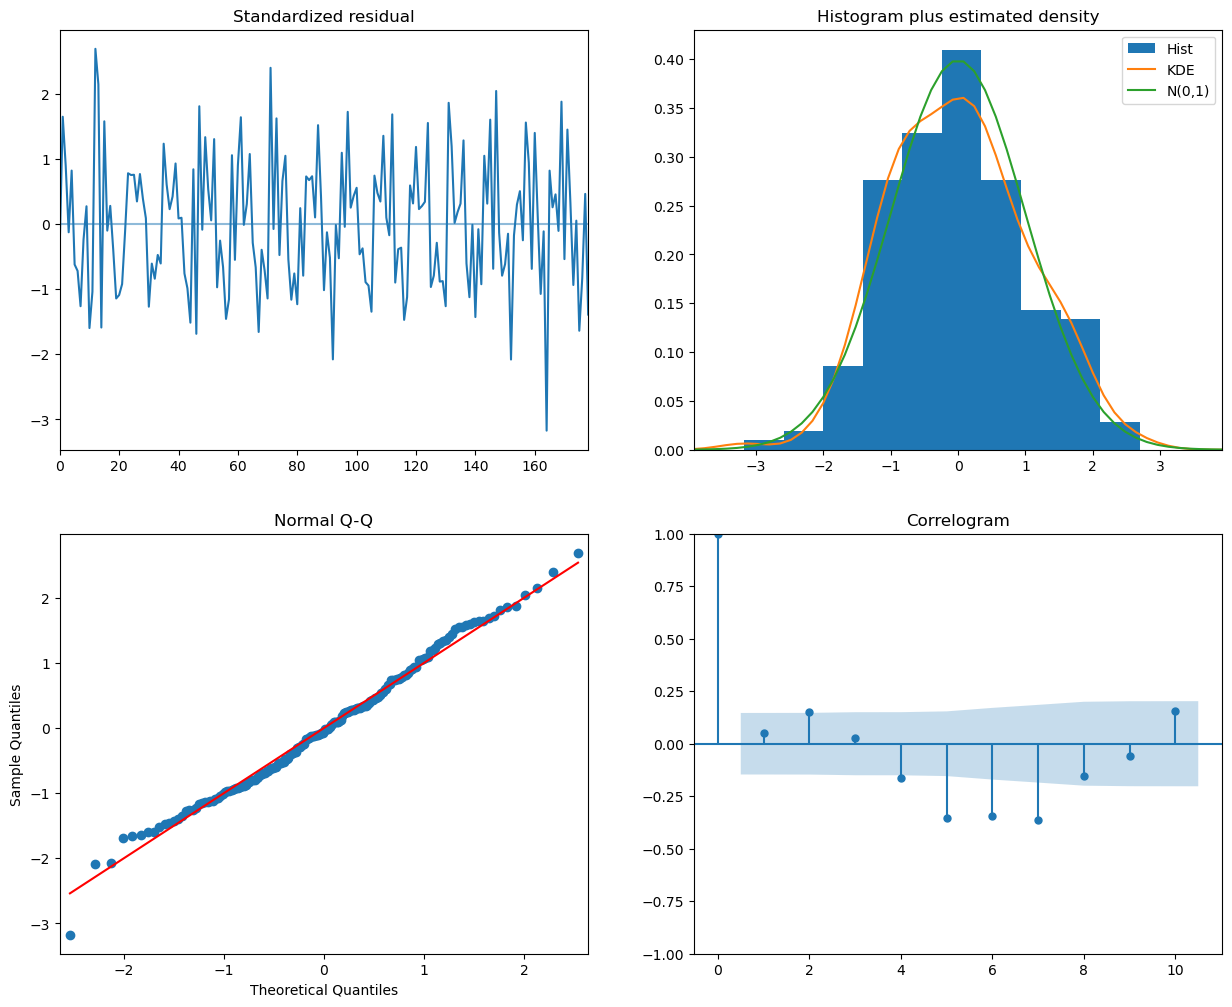

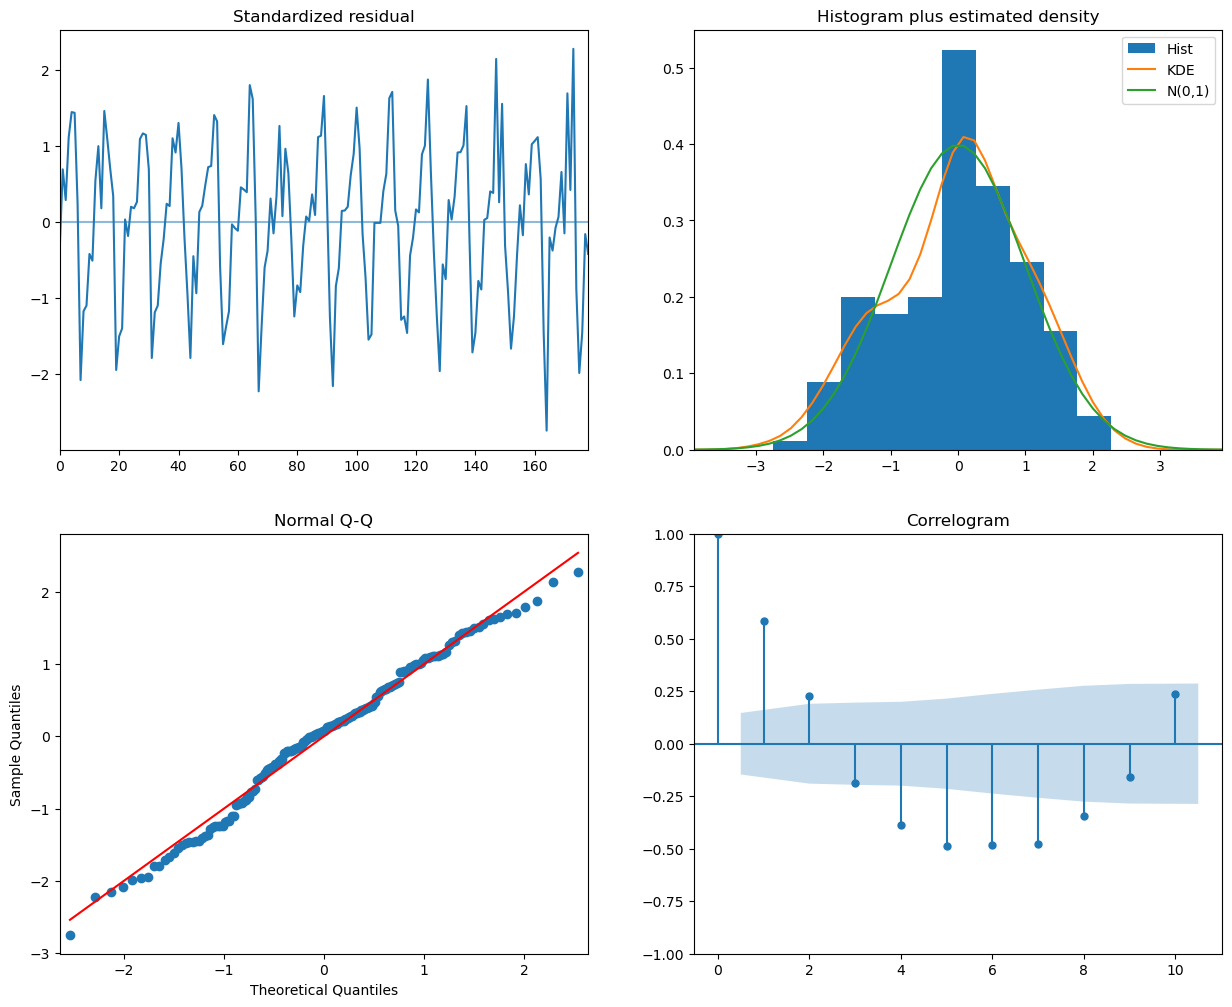

In [3]:
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

train1 = train[0]
test1 = test[0]
validation1 = validation[0]

# Aggregate the original data by getting the median of the weather station temperatures for each month
y_df = results_df.groupby(['Year', 'Month'])['temperatures'].median()
y1 = y_df.values

data = []
for j in range(len(train1)):
    ws_row = []
    for k in range(len(train1[0])):
        Q = train1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures
for j in range(len(test1)):
    ws_row = []
    for k in range(len(test1[0])):
        Q = test1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures
for j in range(len(validation1)):
    ws_row = []
    for k in range(len(validation1[0])):
        Q = validation1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures

# Aggregate the transformed data by getting the median of the weather station temperatures for each month
y_scaled = []

for j in range(len(data[0])):
    ws_row = [] # holds all 105 weather station's temperatures for the same time step to get median value
    for k in range(len(data)):
        ws_row.append(data[k][j])
    y_scaled.append(np.median(ws_row))

# Plot data
plot_data(y1, "Temperature")

#Get rolling statistics
rolling_statistics(pd.DataFrame(y1))

# Run Dickey-Fuller test to check if stationary
ADF(y_scaled, "Temperature")
ADF(y1, "Temperature")

#Run Kruskal-Wallis H Test to check if the population median of each weather station is the same
kruskal_stat, kruskal_pval = kruskal(*[results_df[results_df['file_id'] == f]['temperatures'] for f in results_df['file_id'].unique()])

print(kruskal_stat)
print(kruskal_pval)
    
#Run Shapiro-Wilk Test for normality
normality_test_results = {}
for ws in results_df['file_id'].unique():
    w, pvalue = shapiro(results_df[results_df['file_id'] == ws]['temperatures'])
    normality_test_results[ws] = pvalue
        
# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(*[results_df[results_df['file_id'] == ws]['temperatures'] for ws in results_df['file_id'].unique()])

print("Shapiro-Wilk Test for Normality:")
print(normality_test_results)
print("Levene's Test for Homogeneity of Variances:")
print(levene_stat)
print("Levene p: "+str(levene_p))

# Generate ACF and PACF plots
fig1, axes1 = plt.subplots(2, 1, figsize=(14, 12))

print("Scaled Data:")

# Plot ACF
plot_acf(pd.DataFrame(y_scaled), ax=axes1[0], lags=30, alpha=0.05)
axes1[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(pd.DataFrame(y_scaled), ax=axes1[1], lags=30, alpha=0.05, method='ywm')
axes1[1].set_title('Partial Autocorrelation Function (PACF)')

print("Unscaled Data:")

# Generate ACF and PACF plots
fig2, axes2 = plt.subplots(2, 1, figsize=(14, 12))

# Plot ACF
plot_acf(y_df, ax=axes2[0], lags=30, alpha=0.05)
axes2[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y_df, ax=axes2[1], lags=30, alpha=0.05, method='ywm')
axes2[1].set_title('Partial Autocorrelation Function (PACF)')

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(y=results_df['temperatures'])
plt.title('Box Plot of Temperature')
plt.xlabel('Temperature')
plt.show()

# Decomposing the time series with an appropriate period based on the data's seasonality
decomposition_filled = seasonal_decompose(y_df, model='additive', period=12) # Monthly seasonality

# Plotting the decomposed components of the time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
decomposition_filled.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature')

decomposition_filled.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature')

decomposition_filled.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Month')
ax3.set_ylabel('Temperature')

plt.tight_layout()
plt.show()

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

# Run models
    
# Predict temperature

# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

print("ARIMA Temperature Predictions:")

ARIMA_model_Temp, ARIMA_model_SH = fit_ARIMA_model(temp, temp_val, temp_test, sh, sh_val, sh_test, n_seq)

print(ARIMA_model_Temp.summary())
print(ARIMA_model_SH.summary())

plot_diagnostics(ARIMA_model_Temp)
plot_diagnostics(ARIMA_model_SH)

In [4]:
# SARIMAX Model
   
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

SARIMAX_model_Temp, SARIMAX_model_SH = fit_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq)

print(SARIMAX_model_Temp.summary())
print(SARIMAX_model_SH.summary())

84
10
11
84


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Sun, 01 Jun 2025   AIC                           -323.266
Time:                                         04:03:56   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 210.591
Date:                                 Sun, 01 Jun 2025   AIC                           -403.182
Time:                                         04:03:57   BIC                           -374.496
Sample:                                              0   HQIC                          -391.550
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.002      0.717      0.474      -0.002       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.052
Date:                              Sun, 01 Jun 2025   AIC                           -394.105
Time:                                      04:04:42   BIC                           -374.981
Sample:                                           0   HQIC                          -386.350
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.503      0.133      -0.002       0.015
ar.L1         -0.27

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 01 Jun 2025   AIC                           -463.688
Time:                                      04:04:43   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Sun, 01 Jun 2025   AIC                           -380.117
Time:                                      04:05:15   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    04:05:16   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Sun, 01 Jun 2025   AIC                           -389.170
Time:                                    04:06:21   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 01 Jun 2025   AIC                           -463.688
Time:                                      04:06:22   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Sun, 01 Jun 2025   AIC                           -407.789
Time:                                      04:13:27   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 262.195
Date:                            Sun, 01 Jun 2025   AIC                           -512.390
Time:                                    04:13:40   BIC                           -493.265
Sample:                                         0   HQIC                          -504.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.844      0.399      -0.001       0.002
ma.L1         -0.4374      0.063   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Sun, 01 Jun 2025   AIC                           -407.789
Time:                                      04:27:05   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    04:27:07   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 212.107
Date:                              Sun, 01 Jun 2025   AIC                           -406.214
Time:                                      04:46:58   BIC                           -377.528
Sample:                                           0   HQIC                          -394.582
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.034      0.113      0.910      -0.063       0.071
ar.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 3)x(2, 0, [1], 12)   Log Likelihood                 247.947
Date:                              Sun, 01 Jun 2025   AIC                           -475.894
Time:                                      04:47:29   BIC                           -444.020
Sample:                                           0   HQIC                          -462.970
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.771      0.441      -0.001       0.003
ar.L1         -0.82

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Sun, 01 Jun 2025   AIC                           -380.117
Time:                                      04:53:31   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 265.351
Date:                              Sun, 01 Jun 2025   AIC                           -516.702
Time:                                      04:53:47   BIC                           -494.390
Sample:                                           0   HQIC                          -507.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.002      0.592      0.554      -0.002       0.004
ar.L1         -0.29

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Sun, 01 Jun 2025   AIC                           -378.611
Time:                                    05:05:26   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 259.695
Date:                            Sun, 01 Jun 2025   AIC                           -507.390
Time:                                    05:05:29   BIC                           -488.266
Sample:                                         0   HQIC                          -499.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.230      0.818      -0.002       0.003
ar.L1          0.3077      0.350   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 212.761
Date:                              Sun, 01 Jun 2025   AIC                           -409.523
Time:                                      05:20:50   BIC                           -384.024
Sample:                                           0   HQIC                          -399.183
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0063      0.006      1.135      0.256      -0.005       0.017
ar.L1         -0.52

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Sun, 01 Jun 2025   AIC                           -537.319
Time:                                      05:20:53   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 207.579
Date:                              Sun, 01 Jun 2025   AIC                           -403.158
Time:                                      05:31:26   BIC                           -384.033
Sample:                                           0   HQIC                          -395.403
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.295      0.195      -0.002       0.010
ma.L1         -0.28

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      05:31:29   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    05:39:00   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Sun, 01 Jun 2025   AIC                           -537.319
Time:                                      05:39:03   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Sun, 01 Jun 2025   AIC                           -407.789
Time:                                      05:49:04   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood                 224.739
Date:                                 Sun, 01 Jun 2025   AIC                           -433.477
Time:                                         05:49:15   BIC                           -407.978
Sample:                                              0   HQIC                          -423.138
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.003      0.049      0.961      -0.006       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Sun, 01 Jun 2025   AIC                           -365.528
Time:                                         05:58:47   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Sun, 01 Jun 2025   AIC                           -537.319
Time:                                      05:58:50   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 4)x(1, 0, [1], 12)   Log Likelihood                 206.738
Date:                              Sun, 01 Jun 2025   AIC                           -397.477
Time:                                      06:10:53   BIC                           -371.978
Sample:                                           0   HQIC                          -387.137
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.004      0.907      0.364      -0.005       0.013
ma.L1         -0.30

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      06:10:56   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Sun, 01 Jun 2025   AIC                           -405.568
Time:                                      06:13:56   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 248.912
Date:                    Sun, 01 Jun 2025   AIC                           -489.825
Time:                            06:13:56   BIC                           -477.075
Sample:                                 0   HQIC                          -484.655
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.007      0.314      -0.000       0.001
ar.S.L12       0.9990      0.001   1143.873      0.000       0.997       1.001
ma.S.L12      -0.740

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:14:17   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 244.413
Date:                              Sun, 01 Jun 2025   AIC                           -478.826
Time:                                      06:14:18   BIC                           -462.890
Sample:                                           0   HQIC                          -472.364
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.165      0.869      -0.004       0.005
ar.L1          0.13

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Sun, 01 Jun 2025   AIC                           -407.789
Time:                                      06:15:10   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Sun, 01 Jun 2025   AIC                           -499.174
Time:                                         06:15:11   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:15:46   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:15:47   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                  179
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood                 191.823
Date:                       Sun, 01 Jun 2025   AIC                           -371.646
Time:                               06:16:22   BIC                           -352.521
Sample:                                    0   HQIC                          -363.891
                                       - 179                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.015      0.196      0.844      -0.027       0.033
ar.S.L12       0.3825      7.013      0.055      0.956     -13.362      14.

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      06:16:23   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 184.536
Date:                              Sun, 01 Jun 2025   AIC                           -355.072
Time:                                      06:17:45   BIC                           -332.760
Sample:                                           0   HQIC                          -346.025
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.003      0.941      0.347      -0.003       0.009
ar.L1          0.06

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(5, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.858
Date:                            Sun, 01 Jun 2025   AIC                           -509.715
Time:                                    06:17:47   BIC                           -474.654
Sample:                                         0   HQIC                          -495.498
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.002      0.821      0.412      -0.002       0.006
ar.L1         -0.2203      0.392   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Sun, 01 Jun 2025   AIC                           -389.170
Time:                                    06:18:38   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 01 Jun 2025   AIC                           -463.688
Time:                                      06:18:39   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Sun, 01 Jun 2025   AIC                           -389.170
Time:                                    06:19:36   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:19:37   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Sun, 01 Jun 2025   AIC                           -380.117
Time:                                      06:20:03   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 01 Jun 2025   AIC                           -463.688
Time:                                      06:20:04   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:20:51   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 266.975
Date:                              Sun, 01 Jun 2025   AIC                           -517.949
Time:                                      06:20:52   BIC                           -492.450
Sample:                                           0   HQIC                          -507.610
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.002      0.539      0.590      -0.003       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Sun, 01 Jun 2025   AIC                           -389.170
Time:                                    06:21:51   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 01 Jun 2025   AIC                           -463.688
Time:                                      06:21:51   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Sun, 01 Jun 2025   AIC                           -385.862
Time:                                         06:22:38   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Sun, 01 Jun 2025   AIC                           -537.319
Time:                                      06:22:38   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:23:20   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Sun, 01 Jun 2025   AIC                           -499.174
Time:                                         06:23:20   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:24:02   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      06:24:03   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:24:52   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Sun, 01 Jun 2025   AIC                           -144.249
Time:                                      06:24:52   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    06:25:27   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 265.351
Date:                              Sun, 01 Jun 2025   AIC                           -516.702
Time:                                      06:25:28   BIC                           -494.390
Sample:                                           0   HQIC                          -507.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.002      0.592      0.554      -0.002       0.004
ar.L1         -0.29

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    06:26:08   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:26:08   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:26:34   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 247.760
Date:                            Sun, 01 Jun 2025   AIC                           -481.520
Time:                                    06:26:35   BIC                           -459.209
Sample:                                         0   HQIC                          -472.473
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.003      0.678      0.498      -0.004       0.008
ma.L1          0.0420      0.092   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Sun, 01 Jun 2025   AIC                           -365.528
Time:                                         06:27:09   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood                 248.690
Date:                             Sun, 01 Jun 2025   AIC                           -487.379
Time:                                     06:27:09   BIC                           -471.442
Sample:                                          0   HQIC                          -480.917
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.278      0.201      -0.001       0.006
ma.L1         -0.6444      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Sun, 01 Jun 2025   AIC                           -378.611
Time:                                    06:28:02   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 267.038
Date:                                 Sun, 01 Jun 2025   AIC                           -522.076
Time:                                         06:28:03   BIC                           -502.952
Sample:                                              0   HQIC                          -514.321
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.002      1.162      0.245      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 190.365
Date:                    Sun, 01 Jun 2025   AIC                           -372.729
Time:                            06:28:58   BIC                           -359.980
Sample:                                 0   HQIC                          -367.559
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.004      1.098      0.272      -0.003       0.012
ar.S.L12       0.9917      0.008    130.572      0.000       0.977       1.007
ma.S.L12      -0.776

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 241.629
Date:                              Sun, 01 Jun 2025   AIC                           -465.258
Time:                                      06:28:59   BIC                           -436.572
Sample:                                           0   HQIC                          -453.626
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.482      0.630      -0.001       0.002
ar.L1         -0.20

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Sun, 01 Jun 2025   AIC                           -385.862
Time:                                         06:29:53   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:29:53   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.052
Date:                              Sun, 01 Jun 2025   AIC                           -394.105
Time:                                      06:30:39   BIC                           -374.981
Sample:                                           0   HQIC                          -386.350
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.503      0.133      -0.002       0.015
ar.L1         -0.27

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Sun, 01 Jun 2025   AIC                           -537.319
Time:                                      06:30:40   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Sun, 01 Jun 2025   AIC                           -403.405
Time:                                    06:31:35   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.192
Date:                            Sun, 01 Jun 2025   AIC                           -516.383
Time:                                    06:31:36   BIC                           -494.071
Sample:                                         0   HQIC                          -507.336
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.846      0.398      -0.001       0.002
ar.L1         -0.0965      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 213.913
Date:                            Sun, 01 Jun 2025   AIC                           -413.825
Time:                                    06:32:19   BIC                           -391.514
Sample:                                         0   HQIC                          -404.778
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.002      1.206      0.228      -0.001       0.005
ar.L1          0.4942      0.098   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 259.695
Date:                            Sun, 01 Jun 2025   AIC                           -507.390
Time:                                    06:32:20   BIC                           -488.266
Sample:                                         0   HQIC                          -499.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.230      0.818      -0.002       0.003
ar.L1          0.3077      0.350   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Sun, 01 Jun 2025   AIC                           -323.266
Time:                                         06:33:04   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:33:04   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Sun, 01 Jun 2025   AIC                           -365.528
Time:                                         06:33:53   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      06:33:54   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    06:34:55   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(4, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 245.186
Date:                              Sun, 01 Jun 2025   AIC                           -474.372
Time:                                      06:34:55   BIC                           -448.873
Sample:                                           0   HQIC                          -464.033
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      0.898      0.369      -0.001       0.003
ar.L1         -0.22

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    06:35:45   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 245.285
Date:                            Sun, 01 Jun 2025   AIC                           -474.569
Time:                                    06:35:46   BIC                           -449.070
Sample:                                         0   HQIC                          -464.230
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      0.760      0.447      -0.000       0.001
ar.L1         -0.0249      0.003   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 212.761
Date:                              Sun, 01 Jun 2025   AIC                           -409.523
Time:                                      06:36:28   BIC                           -384.024
Sample:                                           0   HQIC                          -399.183
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0063      0.006      1.135      0.256      -0.005       0.017
ar.L1         -0.52

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:36:28   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(4, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.876
Date:                              Sun, 01 Jun 2025   AIC                           -391.752
Time:                                      06:37:47   BIC                           -366.253
Sample:                                           0   HQIC                          -381.413
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0077      0.006      1.360      0.174      -0.003       0.019
ar.L1         -0.40

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(5, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 259.007
Date:                              Sun, 01 Jun 2025   AIC                           -500.014
Time:                                      06:37:48   BIC                           -471.327
Sample:                                           0   HQIC                          -488.382
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.002      0.841      0.400      -0.002       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Sun, 01 Jun 2025   AIC                           -378.611
Time:                                    06:38:53   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 266.526
Date:                            Sun, 01 Jun 2025   AIC                           -517.052
Time:                                    06:38:54   BIC                           -491.553
Sample:                                         0   HQIC                          -506.712
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.003      0.963      0.335      -0.003       0.008
ar.L1         -0.2545      0.657   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Sun, 01 Jun 2025   AIC                           -369.477
Time:                                    06:39:38   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 266.975
Date:                              Sun, 01 Jun 2025   AIC                           -517.949
Time:                                      06:39:39   BIC                           -492.450
Sample:                                           0   HQIC                          -507.610
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.002      0.539      0.590      -0.003       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Sun, 01 Jun 2025   AIC                           -365.528
Time:                                         06:40:40   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Sun, 01 Jun 2025   AIC                           -144.249
Time:                                      06:40:40   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 190.365
Date:                    Sun, 01 Jun 2025   AIC                           -372.729
Time:                            06:41:27   BIC                           -359.980
Sample:                                 0   HQIC                          -367.559
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.004      1.098      0.272      -0.003       0.012
ar.S.L12       0.9917      0.008    130.572      0.000       0.977       1.007
ma.S.L12      -0.776

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 3)x(2, 0, [1], 12)   Log Likelihood                 227.284
Date:                              Sun, 01 Jun 2025   AIC                           -436.567
Time:                                      06:41:29   BIC                           -407.881
Sample:                                           0   HQIC                          -424.935
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.571      0.568      -0.001       0.002
ar.L1         -0.69

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 182.523
Date:                Sun, 01 Jun 2025   AIC                           -351.046
Time:                        06:42:36   BIC                           -328.735
Sample:                             0   HQIC                          -341.999
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3162      0.019     16.336      0.000       0.278       0.354
ar.L1          0.9418      0.057     16.562      0.000       0.830       1.053
ar.L2         -0.1986      0.082     -2.417      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 262.195
Date:                            Sun, 01 Jun 2025   AIC                           -512.390
Time:                                    06:42:37   BIC                           -493.265
Sample:                                         0   HQIC                          -504.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.844      0.399      -0.001       0.002
ma.L1         -0.4374      0.063   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Sun, 01 Jun 2025   AIC                           -323.266
Time:                                         06:43:17   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:43:18   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Sun, 01 Jun 2025   AIC                           -369.477
Time:                                    06:43:49   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood                 248.690
Date:                             Sun, 01 Jun 2025   AIC                           -487.379
Time:                                     06:43:50   BIC                           -471.442
Sample:                                          0   HQIC                          -480.917
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.278      0.201      -0.001       0.006
ma.L1         -0.6444      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:44:23   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:44:23   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 201.090
Date:                              Sun, 01 Jun 2025   AIC                           -388.179
Time:                                      06:45:05   BIC                           -365.868
Sample:                                           0   HQIC                          -379.132
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0051      0.007      0.758      0.448      -0.008       0.018
ma.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:45:05   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Sun, 01 Jun 2025   AIC                           -385.862
Time:                                         06:45:59   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Sun, 01 Jun 2025   AIC                           -144.249
Time:                                      06:46:00   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Sun, 01 Jun 2025   AIC                           -403.405
Time:                                    06:46:48   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:46:49   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Sun, 01 Jun 2025   AIC                           -380.117
Time:                                      06:47:27   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Sun, 01 Jun 2025   AIC                           -510.458
Time:                                      06:47:28   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:48:10   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Sun, 01 Jun 2025   AIC                           -510.458
Time:                                      06:48:11   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:48:53   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Sun, 01 Jun 2025   AIC                           -499.174
Time:                                         06:48:54   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Sun, 01 Jun 2025   AIC                           -385.862
Time:                                         06:49:48   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Sun, 01 Jun 2025   AIC                           -499.174
Time:                                         06:49:49   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:50:21   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:50:21   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Sun, 01 Jun 2025   AIC                           -403.405
Time:                                    06:51:10   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Sun, 01 Jun 2025   AIC                           -487.880
Time:                                    06:51:12   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:52:14   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Sun, 01 Jun 2025   AIC                           -487.880
Time:                                    06:52:15   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Sun, 01 Jun 2025   AIC                           -403.405
Time:                                    06:53:20   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(4, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 245.186
Date:                              Sun, 01 Jun 2025   AIC                           -474.372
Time:                                      06:53:20   BIC                           -448.873
Sample:                                           0   HQIC                          -464.033
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      0.898      0.369      -0.001       0.003
ar.L1         -0.22

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Sun, 01 Jun 2025   AIC                           -369.477
Time:                                    06:53:45   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:53:45   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Sun, 01 Jun 2025   AIC                           -405.568
Time:                                      06:54:26   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 248.912
Date:                    Sun, 01 Jun 2025   AIC                           -489.825
Time:                            06:54:27   BIC                           -477.075
Sample:                                 0   HQIC                          -484.655
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.007      0.314      -0.000       0.001
ar.S.L12       0.9990      0.001   1143.873      0.000       0.997       1.001
ma.S.L12      -0.740

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    06:55:06   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Sun, 01 Jun 2025   AIC                           -510.458
Time:                                      06:55:06   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    06:55:45   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Sun, 01 Jun 2025   AIC                           -537.319
Time:                                      06:55:46   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Sun, 01 Jun 2025   AIC                           -385.862
Time:                                         06:56:27   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 270.672
Date:                              Sun, 01 Jun 2025   AIC                           -527.344
Time:                                      06:56:28   BIC                           -505.032
Sample:                                           0   HQIC                          -518.297
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.012      0.312      -0.000       0.001
ma.L1         -0.61

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 4)x(2, 0, [1, 2], 12)   Log Likelihood                 204.739
Date:                                 Sun, 01 Jun 2025   AIC                           -389.477
Time:                                         06:57:19   BIC                           -357.604
Sample:                                              0   HQIC                          -376.553
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.011      0.824      0.410      -0.012       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    06:57:19   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Sun, 01 Jun 2025   AIC                           -407.789
Time:                                      06:58:31   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 259.239
Date:                            Sun, 01 Jun 2025   AIC                           -502.478
Time:                                    06:58:33   BIC                           -476.979
Sample:                                         0   HQIC                          -492.138
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.002      0.476      0.634      -0.002       0.004
ar.L1         -0.3005      0.510   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Sun, 01 Jun 2025   AIC                           -405.568
Time:                                      06:59:28   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 267.038
Date:                                 Sun, 01 Jun 2025   AIC                           -522.076
Time:                                         06:59:29   BIC                           -502.952
Sample:                                              0   HQIC                          -514.321
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.002      1.162      0.245      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    07:00:23   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Sun, 01 Jun 2025   AIC                           -487.880
Time:                                    07:00:25   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 184.536
Date:                              Sun, 01 Jun 2025   AIC                           -355.072
Time:                                      07:00:53   BIC                           -332.760
Sample:                                           0   HQIC                          -346.025
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.003      0.941      0.347      -0.003       0.009
ar.L1          0.06

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 232.330
Date:                            Sun, 01 Jun 2025   AIC                           -456.660
Time:                                    07:00:53   BIC                           -443.910
Sample:                                         0   HQIC                          -451.490
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0446      0.016      2.761      0.006       0.013       0.076
ar.L1         -0.2606      0.066   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Sun, 01 Jun 2025   AIC                           -323.266
Time:                                         07:01:40   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.192
Date:                            Sun, 01 Jun 2025   AIC                           -516.383
Time:                                    07:01:42   BIC                           -494.071
Sample:                                         0   HQIC                          -507.336
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.846      0.398      -0.001       0.002
ar.L1         -0.0965      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 207.579
Date:                              Sun, 01 Jun 2025   AIC                           -403.158
Time:                                      07:02:31   BIC                           -384.033
Sample:                                           0   HQIC                          -395.403
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.295      0.195      -0.002       0.010
ma.L1         -0.28

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.192
Date:                            Sun, 01 Jun 2025   AIC                           -516.383
Time:                                    07:02:32   BIC                           -494.071
Sample:                                         0   HQIC                          -507.336
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.846      0.398      -0.001       0.002
ar.L1         -0.0965      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    07:03:17   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Sun, 01 Jun 2025   AIC                           -487.880
Time:                                    07:03:18   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Sun, 01 Jun 2025   AIC                           -403.405
Time:                                    07:04:06   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 267.999
Date:                                 Sun, 01 Jun 2025   AIC                           -521.998
Time:                                         07:04:08   BIC                           -499.686
Sample:                                              0   HQIC                          -512.951
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.003      0.436      0.663      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 203.443
Date:                              Sun, 01 Jun 2025   AIC                           -392.887
Time:                                      07:05:00   BIC                           -370.575
Sample:                                           0   HQIC                          -383.840
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.003      1.305      0.192      -0.002       0.010
ma.L1         -0.20

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 267.092
Date:                              Sun, 01 Jun 2025   AIC                           -520.184
Time:                                      07:05:00   BIC                           -497.872
Sample:                                           0   HQIC                          -511.137
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.842      0.400      -0.001       0.002
ma.L1         -0.37

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Sun, 01 Jun 2025   AIC                           -378.611
Time:                                    07:05:51   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 01 Jun 2025   AIC                           -463.688
Time:                                      07:05:52   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Sun, 01 Jun 2025   AIC                           -378.611
Time:                                    07:06:43   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 01 Jun 2025   AIC                           -463.688
Time:                                      07:06:44   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 212.107
Date:                              Sun, 01 Jun 2025   AIC                           -406.214
Time:                                      07:07:45   BIC                           -377.528
Sample:                                           0   HQIC                          -394.582
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.034      0.113      0.910      -0.063       0.071
ar.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    07:07:46   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.052
Date:                              Sun, 01 Jun 2025   AIC                           -394.105
Time:                                      07:08:26   BIC                           -374.981
Sample:                                           0   HQIC                          -386.350
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.503      0.133      -0.002       0.015
ar.L1         -0.27

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 259.695
Date:                            Sun, 01 Jun 2025   AIC                           -507.390
Time:                                    07:08:26   BIC                           -488.266
Sample:                                         0   HQIC                          -499.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.230      0.818      -0.002       0.003
ar.L1          0.3077      0.350   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 213.913
Date:                            Sun, 01 Jun 2025   AIC                           -413.825
Time:                                    07:09:23   BIC                           -391.514
Sample:                                         0   HQIC                          -404.778
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.002      1.206      0.228      -0.001       0.005
ar.L1          0.4942      0.098   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 266.975
Date:                              Sun, 01 Jun 2025   AIC                           -517.949
Time:                                      07:09:24   BIC                           -492.450
Sample:                                           0   HQIC                          -507.610
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.002      0.539      0.590      -0.003       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Sun, 01 Jun 2025   AIC                           -365.528
Time:                                         07:10:09   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Sun, 01 Jun 2025   AIC                           -499.174
Time:                                         07:10:09   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Sun, 01 Jun 2025   AIC                           -405.568
Time:                                      07:11:23   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Sun, 01 Jun 2025   AIC                           -510.458
Time:                                      07:11:24   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Sun, 01 Jun 2025   AIC                           -323.266
Time:                                         07:12:14   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 270.672
Date:                              Sun, 01 Jun 2025   AIC                           -527.344
Time:                                      07:12:14   BIC                           -505.032
Sample:                                           0   HQIC                          -518.297
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.012      0.312      -0.000       0.001
ma.L1         -0.61

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Sun, 01 Jun 2025   AIC                           -385.862
Time:                                         07:13:34   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 247.760
Date:                            Sun, 01 Jun 2025   AIC                           -481.520
Time:                                    07:13:35   BIC                           -459.209
Sample:                                         0   HQIC                          -472.473
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.003      0.678      0.498      -0.004       0.008
ma.L1          0.0420      0.092   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Sun, 01 Jun 2025   AIC                           -403.405
Time:                                    07:14:22   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Sun, 01 Jun 2025   AIC                           -537.319
Time:                                      07:14:22   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Sun, 01 Jun 2025   AIC                           -369.477
Time:                                    07:15:23   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(4, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 266.879
Date:                            Sun, 01 Jun 2025   AIC                           -513.759
Time:                                    07:15:25   BIC                           -481.885
Sample:                                         0   HQIC                          -500.834
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.871      0.384      -0.001       0.003
ar.L1         -0.0341      0.177   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    07:16:14   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Sun, 01 Jun 2025   AIC                           -499.174
Time:                                         07:16:15   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    07:16:48   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    07:16:49   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    07:17:32   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    07:17:33   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 201.090
Date:                              Sun, 01 Jun 2025   AIC                           -388.179
Time:                                      07:18:09   BIC                           -365.868
Sample:                                           0   HQIC                          -379.132
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0051      0.007      0.758      0.448      -0.008       0.018
ma.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      07:18:10   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 169.791
Date:                                 Sun, 01 Jun 2025   AIC                           -321.581
Time:                                         07:19:13   BIC                           -292.895
Sample:                                              0   HQIC                          -309.949
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.006      1.601      0.109      -0.002       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      07:19:14   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 213.913
Date:                            Sun, 01 Jun 2025   AIC                           -413.825
Time:                                    07:20:40   BIC                           -391.514
Sample:                                         0   HQIC                          -404.778
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.002      1.206      0.228      -0.001       0.005
ar.L1          0.4942      0.098   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Sun, 01 Jun 2025   AIC                           -144.249
Time:                                      07:20:40   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Sun, 01 Jun 2025   AIC                           -407.789
Time:                                      07:21:34   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      07:21:34   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 207.579
Date:                              Sun, 01 Jun 2025   AIC                           -403.158
Time:                                      07:22:16   BIC                           -384.033
Sample:                                           0   HQIC                          -395.403
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.295      0.195      -0.002       0.010
ma.L1         -0.28

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [], 12)   Log Likelihood                 100.362
Date:                             Sun, 01 Jun 2025   AIC                           -188.725
Time:                                     07:22:16   BIC                           -169.600
Sample:                                          0   HQIC                          -180.970
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0082      0.005      1.546      0.122      -0.002       0.019
ma.L1          0.0146      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Sun, 01 Jun 2025   AIC                           -401.530
Time:                                    07:22:57   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Sun, 01 Jun 2025   AIC                           -527.644
Time:                                    07:22:58   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 196.853
Date:                              Sun, 01 Jun 2025   AIC                           -379.705
Time:                                      07:23:30   BIC                           -357.393
Sample:                                           0   HQIC                          -370.658
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0060      0.006      1.013      0.311      -0.006       0.018
ar.L1         -0.13

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                 256.343
Date:                             Sun, 01 Jun 2025   AIC                           -500.687
Time:                                     07:23:31   BIC                           -481.563
Sample:                                          0   HQIC                          -492.932
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      1.391      0.164      -0.000       0.003
ar.L1          0.4810      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    07:24:14   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 262.195
Date:                            Sun, 01 Jun 2025   AIC                           -512.390
Time:                                    07:24:15   BIC                           -493.265
Sample:                                         0   HQIC                          -504.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.844      0.399      -0.001       0.002
ma.L1         -0.4374      0.063   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Sun, 01 Jun 2025   AIC                           -405.568
Time:                                      07:25:20   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      07:25:21   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Sun, 01 Jun 2025   AIC                           -403.179
Time:                                    07:26:07   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Sun, 01 Jun 2025   AIC                           -501.774
Time:                                      07:26:07   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Sun, 01 Jun 2025   AIC                           -323.266
Time:                                         07:27:07   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 270.672
Date:                              Sun, 01 Jun 2025   AIC                           -527.344
Time:                                      07:27:08   BIC                           -505.032
Sample:                                           0   HQIC                          -518.297
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.012      0.312      -0.000       0.001
ma.L1         -0.61

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


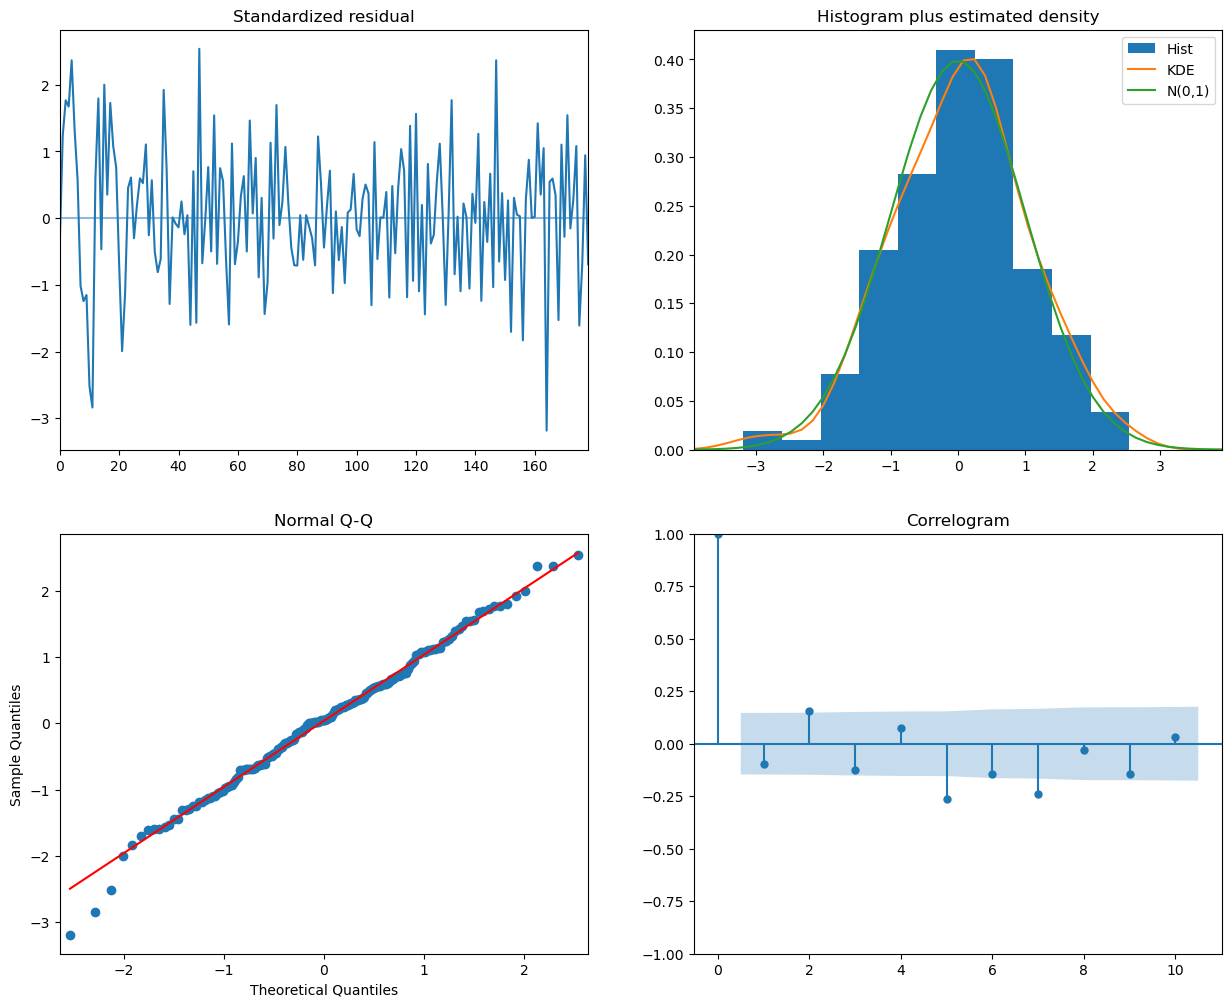

In [5]:
plot_diagnostics(SARIMAX_model_Temp)

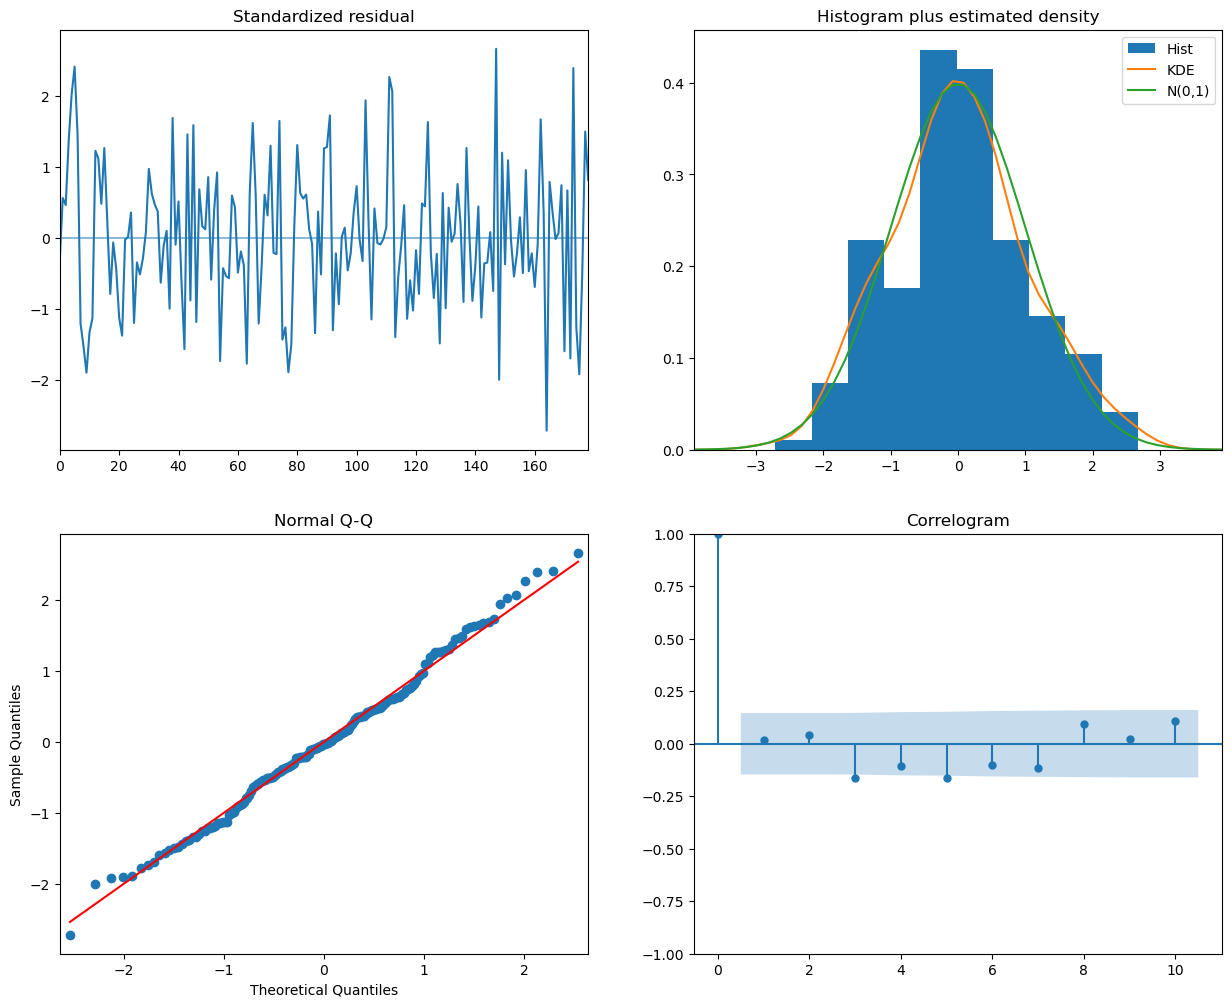

In [6]:
plot_diagnostics(SARIMAX_model_SH)